# Identifying relevant features

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/luigibonati/mlcolvar/blob/main/docs/notebooks/tutorials/adv_features_relevances.ipynb)

## Setup

In [1]:
# Colab setup
import os

if os.getenv("COLAB_RELEASE_TAG"):
    import subprocess
    subprocess.run('wget https://raw.githubusercontent.com/luigibonati/mlcolvar/main/colab_setup.sh', shell=True)
    cmd = subprocess.run('bash colab_setup.sh EXAMPLE', shell=True, stdout=subprocess.PIPE)
    print(cmd.stdout.decode('utf-8'))

# IMPORT PACKAGES
import torch
import lightning
import numpy as np
import matplotlib.pyplot as plt

# Set seed for reproducibility
torch.manual_seed(1)

/home/lbonati@iit.local/software/anaconda3/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Sensitivity analyis

In this notebook we show how to identify the most relevant features for a model using a sensitivity analysis based on the partial derivatives. This has been used to gain insights into the workings of the [Deep-LDA](https://pubs.acs.org/doi/10.1021/acs.jpclett.0c00535) and [DeepTICA](https://www.pnas.org/doi/10.1073/pnas.2113533118https://www.pnas.org/doi/10.1073/pnas.2113533118) CVs.

### Train a ML CV

We will use the DeepLDA CV trained for the [intermolecular aldol reaction](https://colab.research.google.com/github/luigibonati/mlcolvar/blob/main/docs/notebooks/examples/ex_DeepLDA.ipynb) from the [examples](https://mlcolvar.readthedocs.io/en/stable/examples.html) as a case study to explore the sensitivity analysis method.  Of course, the same analysis can be applied also to the other CVs.

In [2]:
from mlcolvar.utils.io import create_dataset_from_files
from mlcolvar.data import DictModule

filenames = [ "https://raw.githubusercontent.com/luigibonati/data-driven-CVs/master/aldol/1_unbiased/INPUTS.R", 
              "https://raw.githubusercontent.com/luigibonati/data-driven-CVs/master/aldol/1_unbiased/INPUTS.P" ]

n_states = len(filenames)

# load dataset
dataset, df = create_dataset_from_files(filenames,
                                        filter_args={'regex':'cc|oo|co|ch|oh' }, # select contacts 
                                        create_labels=True,
                                        return_dataframe=True, 
                                        )

datamodule = DictModule(dataset,lengths=[0.8,0.2])

Class 0 dataframe shape:  (5001, 43)
Class 1 dataframe shape:  (5001, 43)

 - Loaded dataframe (10002, 43): ['time', 'cc2.0', 'cc2.1', 'cc2.2', 'oo2.0', 'co2.0', 'co2.1', 'co2.2', 'co2.3', 'co2.4', 'co2.5', 'ch2.0', 'ch2.1', 'ch2.2', 'ch2.3', 'ch2.4', 'ch2.5', 'ch2.6', 'ch2.7', 'ch2.8', 'ch2.9', 'ch2.10', 'ch2.11', 'ch2.12', 'ch2.13', 'ch2.14', 'ch2.15', 'ch2.16', 'ch2.17', 'oh2.0', 'oh2.1', 'oh2.2', 'oh2.3', 'oh2.4', 'oh2.5', 'oh2.6', 'oh2.7', 'oh2.8', 'oh2.9', 'oh2.10', 'oh2.11', 'walker', 'labels']
 - Descriptors (10002, 40): ['cc2.0', 'cc2.1', 'cc2.2', 'oo2.0', 'co2.0', 'co2.1', 'co2.2', 'co2.3', 'co2.4', 'co2.5', 'ch2.0', 'ch2.1', 'ch2.2', 'ch2.3', 'ch2.4', 'ch2.5', 'ch2.6', 'ch2.7', 'ch2.8', 'ch2.9', 'ch2.10', 'ch2.11', 'ch2.12', 'ch2.13', 'ch2.14', 'ch2.15', 'ch2.16', 'ch2.17', 'oh2.0', 'oh2.1', 'oh2.2', 'oh2.3', 'oh2.4', 'oh2.5', 'oh2.6', 'oh2.7', 'oh2.8', 'oh2.9', 'oh2.10', 'oh2.11']


In [3]:
from mlcolvar.cvs import DeepLDA

n_input           = dataset['data'].shape[-1]
nodes             = [40,30,30,5]
nn_args           = {'activation': 'shifted_softplus'}
options           = {'nn': nn_args}
# MODEL
model = DeepLDA(nodes, n_states=n_states, options=options)

In [4]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from mlcolvar.utils.trainer import MetricsCallback

# define callbacks
metrics = MetricsCallback()
early_stopping = EarlyStopping(monitor="valid_loss", min_delta=0.1, patience=50)

# define trainer
trainer = lightning.Trainer(callbacks=[metrics, early_stopping],
                     max_epochs=None, logger=None, enable_checkpointing=False)

# fit
trainer.fit( model, datamodule )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/lbonati@iit.local/software/anaconda3/envs/pytorch/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
/home/lbonati@iit.local/software/anaconda3/envs/pytorch/lib/python3.10/site-packages/lightning/pytorch/loops/utilities.py:70: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_ep

/home/lbonati@iit.local/software/anaconda3/envs/pytorch/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 566: 100%|██████████| 1/1 [00:00<00:00, 15.65it/s, v_num=75] 


### Features relevance  

#### Introduction

One way to compute the feature importances is to perform a sensitivity analysis using the partial derivatives method. 

In this method, we start by computing the gradients of the CV with respect to the input features $x_i$, over a dataset $\{\mathbf{x}^{(j)}\}_{j=1} ^N$:

$$\left( \frac{\partial s}{\partial x_i}(\mathbf{x}^{(j)})\  \right) \sigma_i$$

where $\sigma_i$ is the standard deviation of the i-th feature, which is needed if the dataset is not standardized.

Once we have the sensitivity per sample, we can calculate an aggregated value per feature using:

- the mean of the absolute values: $$s_i = \frac{1}{N} \sum_j \left|{\frac{\partial s}{\partial x_i}(\mathbf{x}^{(j)})}\right| \sigma_i$$

- the root mean square values: $$s_i = \sqrt{\frac{1}{N} \sum_j \left({\frac{\partial s}{\partial x_i}(\mathbf{x}^{(j)})}\  \sigma_i\right)^2 }$$

- just the mean: $$s_i = \frac{1}{N} \sum_j {\frac{\partial s}{\partial x_i}(\mathbf{x}^{(j)})}\  \sigma_i$$

Notes:
- As we will show below, if we have a labeled dataset, we can restrict this analysis to get per-class statistics by averaging only on a subset of samples ($j \in A,B,...$)
- Since it is based on the derivatives of the model, we have found it to work well with smooth activation functions such as the `shifted_softplus`.

#### Perform the sensitivity analysis

The sensitivity analysis is computed by the function `mlcolvar.utils.explain.sensitivity_analysis` which takes a model and a dataset as compulsory arguments. It can directly plot the features but in this case we will do it later and set `plot_mode=None`. 

In [5]:
from mlcolvar.utils.explain import sensitivity_analysis

results = sensitivity_analysis(model,               
                               dataset, 
                               metric="mean_abs_val",   # metric to use to compute the sensitivity per feature (e.g. mean absolute value or root mean square)
                               feature_names=None,      # by default, they will be taken from `dataset.feature_names` 
                               per_class=False,         # whether to do per-class statistics
                               plot_mode=None)          # plot mode (see below) 

The results are stored in a dictionary, which contains the `feature_names` (ranked according to the metric), the sensitivity calculated on the whole dataset, and the per-sample gradients (useful for more detailed analyisis).

In [6]:
print( 'results: ', list(results.keys()) ) 
print( '\nfeature_names: ', results['feature_names'].shape ) 
print( '\nsensitivity: ')
for key, val in results['sensitivity'].items():
    print(f'- "{key}":  {val.shape}') 

print( '\ngradients: ')
for key, val in results['gradients'].items():
    print(f'- "{key}":  {val.shape}') 


results:  ['feature_names', 'sensitivity', 'gradients']

feature_names:  (40,)

sensitivity: 
- "Dataset":  (40,)

gradients: 
- "Dataset":  (10002, 40)


#### Per-class statistics

If the dataset is labeled we can also compute the sensitivity by averaging only on the corresponding subsets, using `per_class=True`:

In [7]:
from mlcolvar.utils.explain import sensitivity_analysis

results = sensitivity_analysis(model, dataset, plot_mode=None, per_class=True ) 

print( 'sensitivity: ')
for key, val in results['sensitivity'].items():
    print(f'- "{key}":  {val.shape}') 

print( '\ngradients: ')
for key, val in results['gradients'].items():
    print(f'- "{key}":  {val.shape}') 

sensitivity: 
- "Dataset":  (40,)
- "State 0":  (40,)
- "State 1":  (40,)

gradients: 
- "Dataset":  (10002, 40)
- "State 0":  (5001, 40)
- "State 1":  (5001, 40)


#### Specify the standard deviation

By default, the standard deviation $\sigma_i$ will be calculated from the dataset. However, one might want to compute the sensitivity only for a given subset (e.g. only one state). In this case, the standard deviation to use it the one of the dataset on which the CV has been trained on. This can be accomplished in the following way:

In [8]:
# compute std over all dataset
std = dataset.get_stats()["data"]["std"].detach().numpy()

# compute subset
idxs = torch.argwhere ( dataset['labels'] == 0. ) [:,0]
with torch.no_grad():
    subset = dataset[idxs]

results = sensitivity_analysis(model, 
                               dataset = subset, 
                               std = std, 
                               feature_names = dataset.feature_names,
                               plot_mode=None ) 

### Plot 

They results of the sensitivity analysis can be plotted either directly from the `sensitivity_analysis` function or with the function `mlcolvar.utils.plot.plot_sensitivity`, which allows for more customization. The modes implemented are:

* Violin plot ('violin')        showing the density of per-sample sensitivities besides the mean value
* Scatter ('scatter')           plotting the mean and standard deviation of the gradients
* Horizontal bar plot ('barh')  only displaying the mean of the gradients

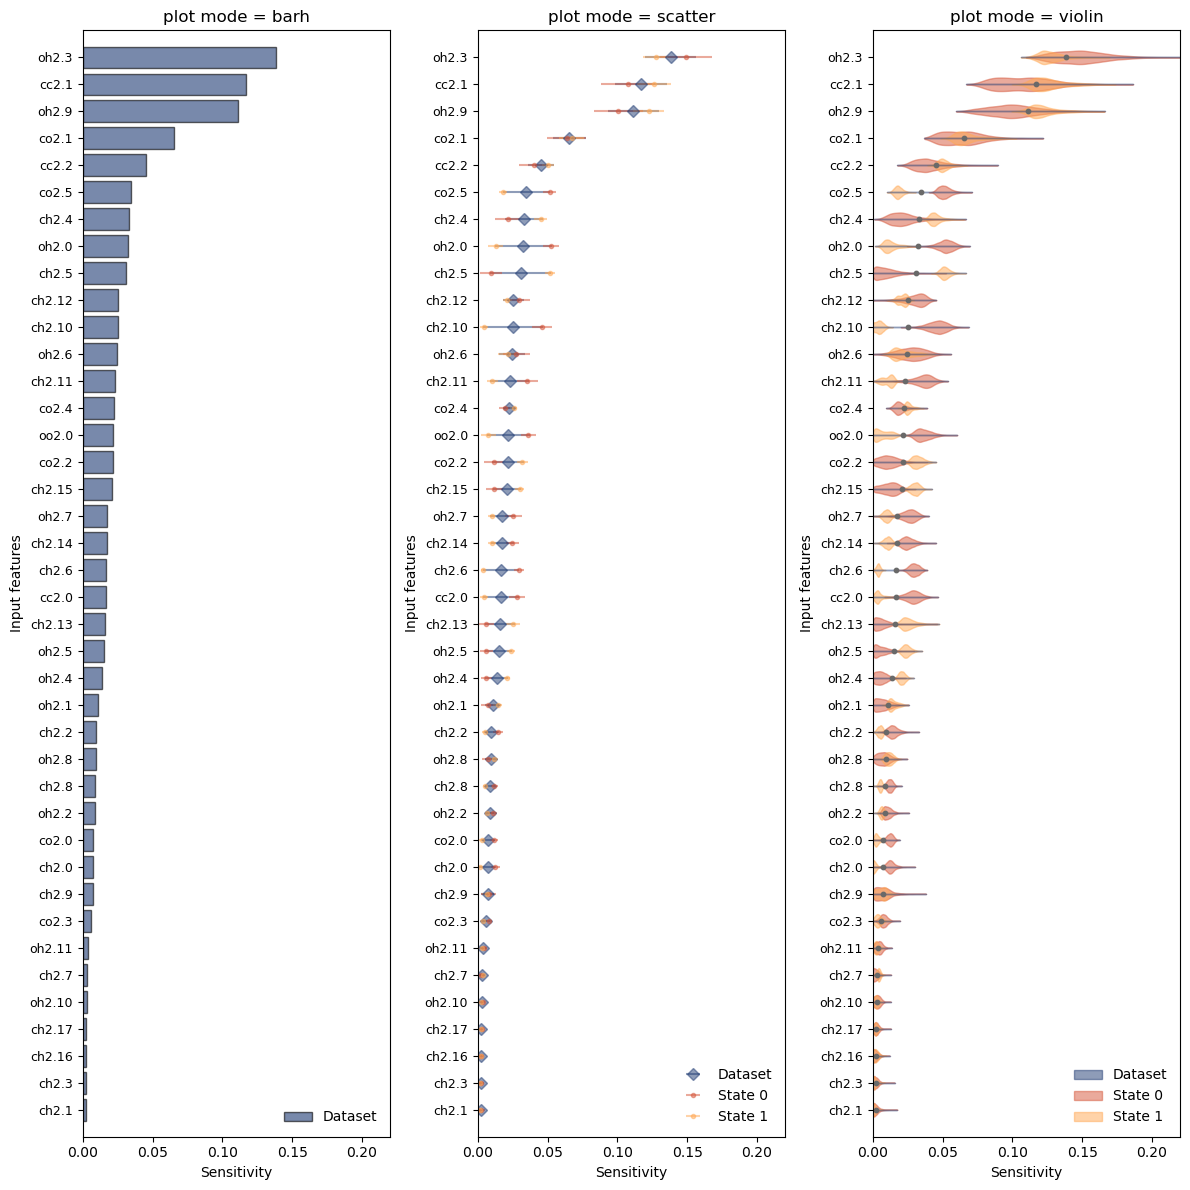

In [9]:
from mlcolvar.utils.plot import plot_sensitivity

# Compute sensitivity 
from mlcolvar.utils.explain import sensitivity_analysis

results = sensitivity_analysis(model, dataset, per_class=True, plot_mode=None)

# Plot sensitivity
fig,axs = plt.subplots(1,3,figsize=(12,12))

modes = ['barh','scatter','violin']
per_class = [False,True,True]
for i,ax in enumerate(axs):
    mode = modes[i]
    plot_sensitivity(results,mode=mode,per_class=per_class[i],ax=ax)
    ax.set_title(f'plot mode = {mode}')
    ax.set_xlim(0,0.22)

plt.tight_layout()

#### Show a given number of features

By default, only the first `max_features=50` are shown, but one can customize this behavior: 

Plotting only the first 20 features out of 40.


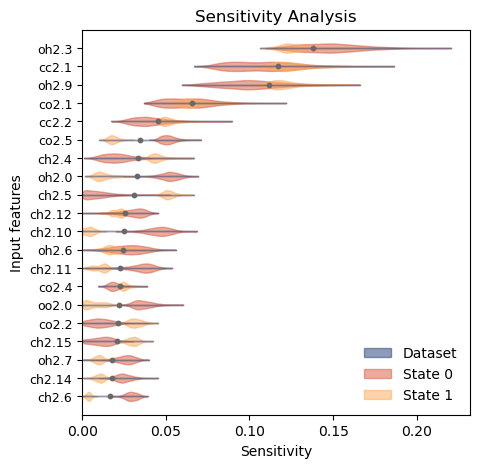

In [10]:
plot_sensitivity(results, mode='violin', per_class=True, max_features=20)
plt.show()

### Reduce the number of inputs

The sensitivity analysis can be also used to reduce the number of input descriptors. As an example, in the [DeepTICA](https://www.pnas.org/doi/10.1073/pnas.2113533118https://www.pnas.org/doi/10.1073/pnas.2113533118) paper, a first variable was obtained using a large number (~4500 inputs) of descriptors, then the sensitivity analysis was performed and a new CV was optimized using only a subset of the inputs (~200).

A new dataset can be indeed created in the following way:

In [11]:
from mlcolvar.data import DictDataset

n_features = 10

relevant_features = results['feature_names'][-n_features:]

# create new dataset
dataset = DictDataset(data=df[relevant_features].values,labels=df['labels'])
dataset

DictDataset( "data": [10002, 10], "labels": [10002] )